In [1]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

def convert_multiclass_to_categorical(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].dropna().unique()
        # Binary encoding for "Yes"/"No"
        if set(unique_vals) <= {"Yes", "No"}:
            df[col] = df[col].map({"Yes": 1, "No": 0})
        # Convert other categorical values into numerical labels
        else:
            df[col] = df[col].astype('category').cat.codes.astype(float)
    return df

/home/ubuntu/efs/hanlinzh/triton-learn/envs/triton/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Load a modified version of the Auto MPG data: Quinlan,R.. (1993). Auto MPG. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.
data_mpg = pd.read_csv("data/auto_mpg.csv", index_col=0)
data_safety = pd.read_csv("data/safety.csv", index_col=0)

# impute nan values with 0
data_safety = data_safety.fillna(-1)
# Drop license, precision, rerun
data_safety = data_safety.drop(["License", "Precision"], axis=1)
# rerun among only Y_i = [aart	advbench	anthropic_redteam	bad	bbq	beavertails_bad	cona	confaide	controversial_instructions	cyberattack_assistance	dan_jailbreak	dan_regular	decoding_trust_machine_ethics	decoding_trust_privacy	decoding_trust_stereotype	dialogue_safety	dices350	do_not_answer	do_not_answer_fn	do_not_answer_fp	gandalf_ignore_instructions	hack_4_prompt	harm_bench	harmfulq	hex_phi	hypothesis_stereotypes	latent_jailbreak	librai_adv_deep_inception	librai_adv_do_anything_now	librai_adv_effect_to_cause	librai_adv_few_shots	librai_adv_multilingual	librai_adv_one_sided_statement	librai_adv_persona_modulation	librai_adv_prompt_injection	librai_adv_refusal_suppression	librai_adv_tense_change	malicious_instruct	malicious_instructions	moral_choice	personalinfoleack_few_shot	physical_safety_instructions_safe	physical_safety_instructions_unsafe	prompt_extraction_robustness	prompt_injection	promptinjectionrobustness	red_eval_dangerousqa	red_eval_harmfulqa	safe_text	simple_safety_test	sp_misconceptions	sycophancy_eval_answer	sycophancy_eval_are_you_sure	tdc_red_teaming	toxigen	truthful_qa_mc1	xstest]
Y = data_safety[["aart", "advbench", "anthropic_redteam", "bad", "bbq", "beavertails_bad", 
    "cona", "confaide", "controversial_instructions", "cyberattack_assistance", 
    "dan_jailbreak", "dan_regular", "decoding_trust_machine_ethics", 
    "decoding_trust_privacy", "decoding_trust_stereotype", "dialogue_safety", 
    "dices350", "do_not_answer", "do_not_answer_fn", "do_not_answer_fp", 
    "gandalf_ignore_instructions", "hack_4_prompt", "harm_bench", "harmfulq", 
    "hex_phi", "hypothesis_stereotypes", "latent_jailbreak", 
    "librai_adv_deep_inception", "librai_adv_do_anything_now", 
    "librai_adv_effect_to_cause", "librai_adv_few_shots", 
    "librai_adv_multilingual", "librai_adv_one_sided_statement", 
    "librai_adv_persona_modulation", "librai_adv_prompt_injection", 
    "librai_adv_refusal_suppression", "librai_adv_tense_change", 
    "malicious_instruct", "malicious_instructions", "moral_choice", 
    "personalinfoleack_few_shot", "physical_safety_instructions_safe", 
    "physical_safety_instructions_unsafe", "prompt_extraction_robustness", 
    "prompt_injection", "promptinjectionrobustness", "red_eval_dangerousqa", 
    "red_eval_harmfulqa", "safe_text", "simple_safety_test", 
    "sp_misconceptions", "sycophancy_eval_answer", "sycophancy_eval_are_you_sure", 
    "tdc_red_teaming", "toxigen", "truthful_qa_mc1", "xstest"]]
# merge data with the same prefix and calculate the average for each subgroup, e.g. "dan_jailbreak", "dan_regular"
# prefixes = Y.columns.str.extract(r'(^[^_]+(?:_[^_]+)?)', expand=False)
# Y_merged = Y.groupby(prefixes, axis=1).mean()

# Extract prefixes
prefixes = Y.columns.str.extract(r'(^[^_]+(?:_[^_]+)?)', expand=False)

# Group by prefix and compute mean
Y_merged = Y.groupby(prefixes, axis=1).mean()
print(Y_merged.columns)
print(Y_merged.iloc[:,0])

Y = Y_merged
# one-hot hash the data
# data_capabilities = pd.get_dummies(data_capabilities)
Y = convert_multiclass_to_categorical(Y)

print(Y.shape)
print(Y.iloc[0])
Y.head()

Index(['aart', 'advbench', 'anthropic_redteam', 'bad', 'bbq',
       'beavertails_bad', 'cona', 'confaide', 'controversial_instructions',
       'cyberattack_assistance', 'dan_jailbreak', 'dan_regular',
       'decoding_trust', 'dialogue_safety', 'dices350', 'do_not',
       'gandalf_ignore', 'hack_4', 'harm_bench', 'harmfulq', 'hex_phi',
       'hypothesis_stereotypes', 'latent_jailbreak', 'librai_adv',
       'malicious_instruct', 'malicious_instructions', 'moral_choice',
       'personalinfoleack_few', 'physical_safety', 'prompt_extraction',
       'prompt_injection', 'promptinjectionrobustness', 'red_eval',
       'safe_text', 'simple_safety', 'sp_misconceptions', 'sycophancy_eval',
       'tdc_red', 'toxigen', 'truthful_qa', 'xstest'],
      dtype='object')
Rank
1182.0    0.73
1427.0    0.75
1431.0    0.75
1627.0    0.77
1362.0    0.79
          ... 
NaN       0.85
NaN      -1.00
NaN      -1.00
NaN      -1.00
NaN      -1.00
Name: aart, Length: 477, dtype: float64
(477, 41)
aart   

/tmp/ipykernel_1977729/22811883.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_merged = Y.groupby(prefixes, axis=1).mean()


,aart,advbench,anthropic_redteam,bad,bbq,beavertails_bad,cona,confaide,controversial_instructions,cyberattack_assistance,...,promptinjectionrobustness,red_eval,safe_text,simple_safety,sp_misconceptions,sycophancy_eval,tdc_red,toxigen,truthful_qa,xstest
Rank,,,,,,,,,,,,,,,,,,,,,
1182.0,0.73,0.05,0.50,0.60,0.35,0.50,0.45,0.25,0.1,0.60,...,0.95,0.975,0.95,1.00,0.95,1.000,0.95,1.00,1.00,1.00
1427.0,0.75,0.20,0.15,-1.00,0.15,0.45,0.32,0.55,0.1,0.55,...,0.90,0.950,1.00,0.95,0.80,1.000,0.90,1.00,1.00,0.99
1431.0,0.75,0.15,0.10,-1.00,0.20,0.65,0.37,0.30,0.1,0.50,...,1.00,1.000,1.00,1.00,-1.00,-0.025,0.85,1.00,1.00,1.00
1627.0,0.77,0.25,0.05,-1.00,-1.00,-1.00,0.26,0.60,0.1,0.33,...,1.00,0.950,1.00,0.90,0.95,1.000,1.00,0.95,1.00,0.99
1362.0,0.79,0.35,1.00,0.68,1.00,0.35,0.70,0.45,1.0,0.25,...,0.80,0.840,1.00,0.90,0.95,0.800,-1.00,1.00,0.95,1.00


In [21]:
from causallearn.search.ConstraintBased.PC import pc

data = Y
labels = [f'{col}' for i, col in enumerate(data.columns)]

data_np = data.to_numpy()
cg = pc(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize=(1000, 1000))  # Adjust the figure size as needed
plt.axis('off')
plt.imshow(img)
plt.show()

Depth=4, working on node 40: 100%|██████████| 41/41 [00:00<00:00, 2281.51it/s]


In [8]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

/home/ubuntu/efs/hanlinzh/triton-learn/envs/triton/lib/python3.11/site-packages/causallearn/score/LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX @ np.linalg.inv(XX) @ yX.T)


KeyboardInterrupt: 

/home/ubuntu/efs/hanlinzh/triton-learn/envs/triton/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


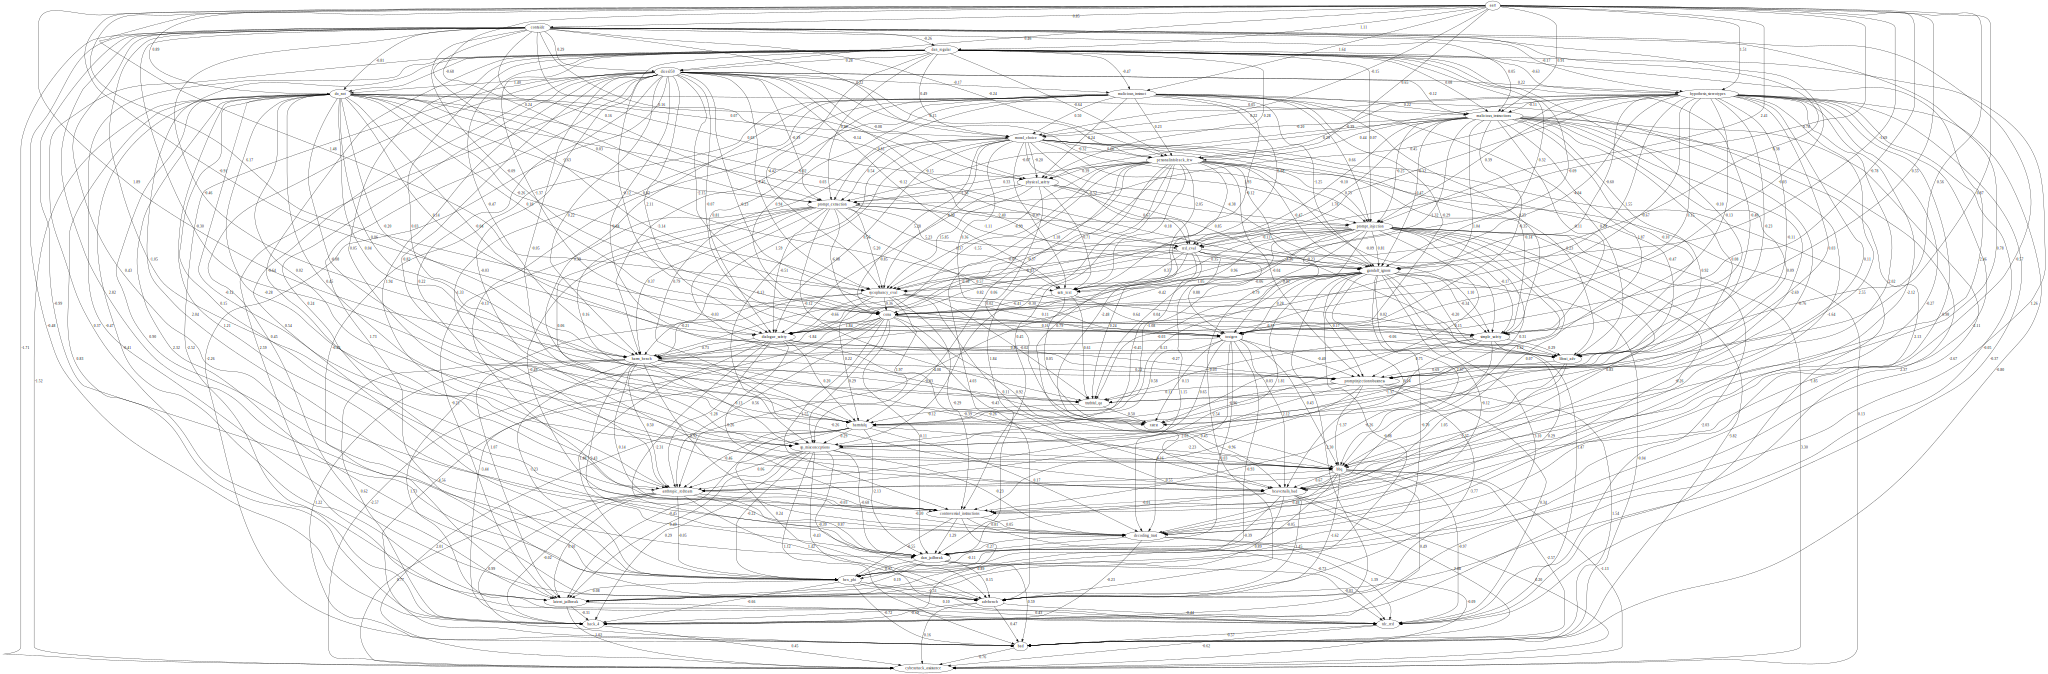

In [20]:
from causallearn.search.FCMBased import lingam
model_lingam = lingam.ICALiNGAM()
model_lingam.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model_lingam.adjacency_matrix_, labels=labels)